In [1]:
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [3]:
train = True
fashion = True

batch_size = 128
n_epochs = 20
lr = 0.001

store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

In [25]:
def show_images(images, title=""):
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
    
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            if i < len(images):
                plt.imshow(images[i][0], cmap=plt.cm.gray)
                i += 1
    
    fig.suptitle(title, fontsize=30)
    
    plt.show()

In [26]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "images")
        break

In [6]:
transform = Compose([
    ToTensor(), # autoatically normalize pixels from (0,255) to (0, 1)
    Lambda(lambda x: (x - 0.5) * 2) # shits the pixels from (0, 1) to (-1, 1)
])

ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:07<00:00, 3306047.80it/s]


Extracting ./datasets\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./datasets\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 233565.11it/s]


Extracting ./datasets\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./datasets\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2313421.59it/s]


Extracting ./datasets\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./datasets\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets\FashionMNIST\raw



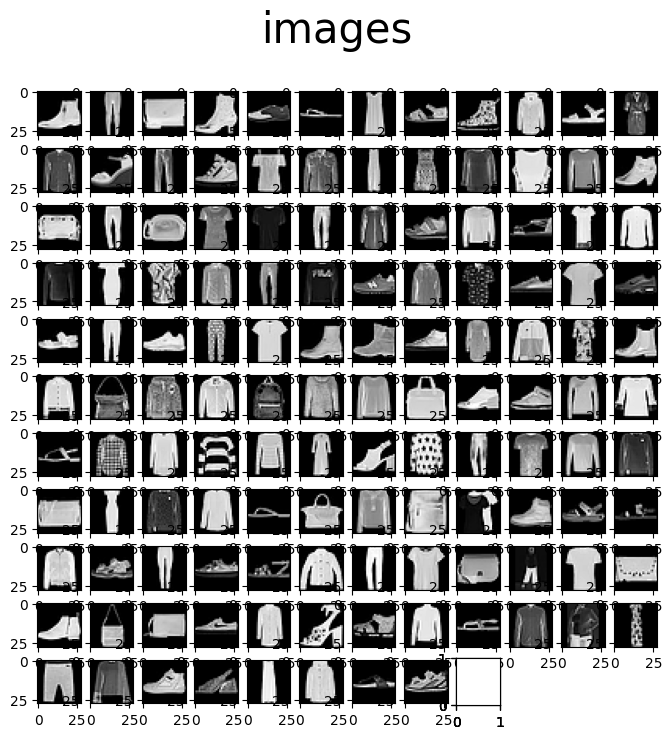

In [27]:
show_first_batch(loader)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
class DDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10**-4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(DDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)
    
    def forward(self, x0, t, epsilon=None):
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if epsilon is None:
            epsilon = torch.randn(n, c, h, w).to(self.device) # automatically standard gaussian distribution
    
        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * epsilon # each batch has its unique t

        return noisy
    
    def backward(self, x, t):
        return self.network(x, t)

In [32]:
def show_forward(ddpm, loader, device):
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original Images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(ddpm(imgs.to(device), [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]), f"DDPM Noisy images {int(percent * 100)}%")
        return

In [33]:
def sample_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device
        
        x = torch.randn(n_samples, c, h, w).to(device)
        
        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            epsilon_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            x = (torch.sqrt(1 / alpha_t)) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_t_bar) * epsilon_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                sigma_t = torch.sqrt(alpha_t / (1 - alpha_t) + 1 / (1 - alpha_t_bar))
                x = x + sigma_t * z
            
            if idx in frame_idxs or t == 0:
                normalized = x.clone()
                
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 /  torch.max(normalized[i])
                
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** (1/2)))
                frame = frame.cpu().numpy().astype(np.uint8)

                frames.append(frame)
    
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    
    return x
